# Neural Modelling Exercise 5
Submitted by **Mohammed Abbas Ansari** and **Kai Rothe**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

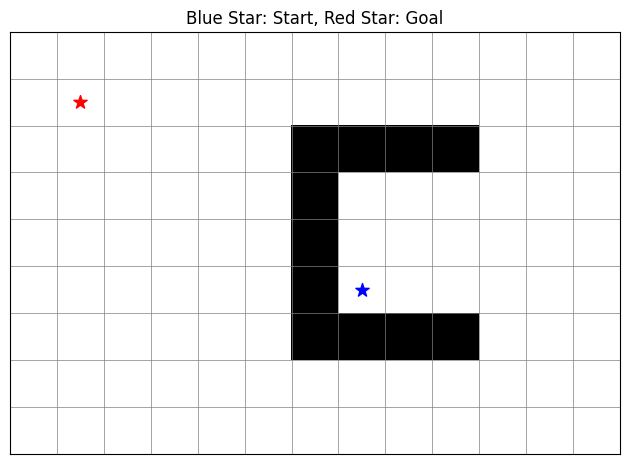

In [2]:
# define maze
maze = np.zeros((9, 13))

# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = np.array([5, 7])

# define goal (we abuse function scoping a bit here, later we will change the goal, which will automatically change the goal in our actor critic as well)
goal = np.array([1, 1])
goal_state = goal[0]*maze.shape[1] + goal[1]
goal_value = 10

def plot_maze(maze, start = start, goal = goal):
    plt.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        plt.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        plt.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)

    plt.xticks([])
    plt.yticks([])

    plt.scatter(start[1], start[0], marker='*', color='blue', s=100)
    plt.scatter(goal[1], goal[0], marker='*', color='red', s=100)

def plot_path(maze, path):
    # plot a maze and a path in it
    plt.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        plt.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        plt.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)

    plt.xticks([])
    plt.yticks([])
    
    path = np.array(path)
    plt.plot(path[:, 1], path[:, 0], c='green', lw=3)
    plt.scatter(path[0, 1], path[0, 0], marker='*', color='blue', s=100)
    plt.scatter(path[-1, 1], path[-1, 0], marker='*', color='red', s=100)

plt.title('Blue Star: Start, Red Star: Goal')
plot_maze(maze)
plt.tight_layout()
plt.show()

## Part 1: Actor-Critic function

program an actor critic algorithm to navigate the maze, using a table of action propensities M with softmax action selection as actor, and a learned state-value function as critic

In [3]:
# implement the actor-critic algorithm to learn to navigate the maze

def state_to_position(state):
    return np.array([state // maze.shape[1], state % maze.shape[1]])

def position_to_state(position):
    return position[..., 0] * maze.shape[1] + position[..., 1]

def invalid_position(position):
    return not (position[..., 0] >= 0 and position[..., 0] < maze.shape[0] and position[..., 1] >= 0 and position[..., 1] < maze.shape[1] and maze[position[..., 0], position[..., 1]] == 0)

def softmax_policy(M, invalid_mask):
    # mask out invalid actions
    exp_x = np.exp(M - np.max(M))
    exp_x[invalid_mask] = 0.
    return exp_x / (exp_x.sum() + 1e-8)

def normal_start():
    # suggested encoding of 2D location onto states
    state = start[0]*maze.shape[1] + start[1]
    return state

def actor_critic(state_representation, n_steps, alpha, gamma, n_episodes, update_sr=False, start_func=normal_start, v_init=0, gamma_sr = 0.8):
    # state_representation is a matrix of size n_states by n_states, giving us the representation for each, which is either a 1-hot vector
    # # (so e.g. state_representation[15] is a vector of size n_states which is 0 everwhere, except 1 at index 15), or the SR for each state
    # n_steps is the number of actions in each episode before it gets cut off, an episode also ends when the agent reaches the goal
    # alpha and gamma are the learning rate and discount factor respectively
    # n_episodes is the number of episodes to train the agent
    # update_sr is for exercise part 3, when you want to update the SR after each episode
    # start_func allows you to specify a different starting state, if desired

    # initialize M-table
    n_states = state_representation.shape[0]
    moves = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    M = np.zeros((n_states, len(moves)))

    # initialize state-value function
    V_weights = np.full(n_states, v_init, dtype=np.float64) 

    earned_rewards = np.zeros(n_episodes)
    final_goal_path = None

    # iterate over episodes
    for episode in range(n_episodes):
        # initializations
        start_state = start_func()
        state_trajectory = []
        position_trajectory = []
        state_trajectory.append(start_state)
        position_trajectory.append(state_to_position(start_state))

        # go until goal is reached
        for t in range(n_steps):
            # pick a valid action
            state = state_trajectory[-1]
            position = position_trajectory[-1]
            next_positions = position + moves
            invalid_mask = np.array([invalid_position(p) for p in next_positions])
            probability = softmax_policy(M[state, :], invalid_mask)
            action = np.random.choice(len(moves), p=probability)
            next_position = next_positions[action]
            
            # store new state
            position_trajectory.append(next_position)
            new_state = position_to_state(next_position)
            state_trajectory.append(new_state)

            # critic update
            delta = gamma * V_weights[new_state] - V_weights[state] # + reward = 0
            V_weights += alpha * delta * state_representation[state] # dV(s, w)/dw = X(s)
            
            # actor update
            log_gradient = - probability # dPi_m(a'|s)/dm = - Pi_m(a'|s)
            log_gradient[action] += 1 # dPi_m(a|s)/dm = (1 - Pi_m(a|s))
            M[state, :] += alpha * delta * gamma**t * log_gradient 

            if update_sr:
                # update state representation 
                delta_sr = gamma_sr * state_representation[new_state] - state_representation[state]
                delta_sr[state] += 1 
                state_representation[state] += alpha * delta_sr

            # check if goal is reached
            if np.all(next_position == goal):
                # update values of last state (because break) without taking an action
                delta = goal_value - V_weights[new_state] # + gamma * V_weights[state_after_goal] = 0
                V_weights += alpha * delta * state_representation[new_state]

                if update_sr:
                    delta_sr = - state_representation[new_state]
                    delta_sr[new_state] += 1
                    state_representation[new_state] += alpha * delta_sr

                # update earned rewards
                earned_rewards[episode] = gamma**t * goal_value
                final_goal_path = position_trajectory

                break


    return M, V_weights, earned_rewards, final_goal_path

In [4]:
one_hot_representation = np.eye(maze.size)

n_steps = 300
alpha = 0.05
gamma = 0.99
n_episodes = 1000
M, V, earned_rewards, example_goal_path = actor_critic(one_hot_representation, n_steps=n_steps, alpha=alpha, gamma=gamma, n_episodes=n_episodes)

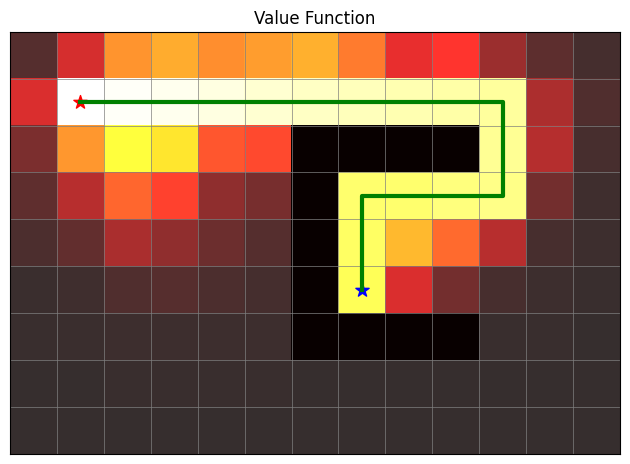

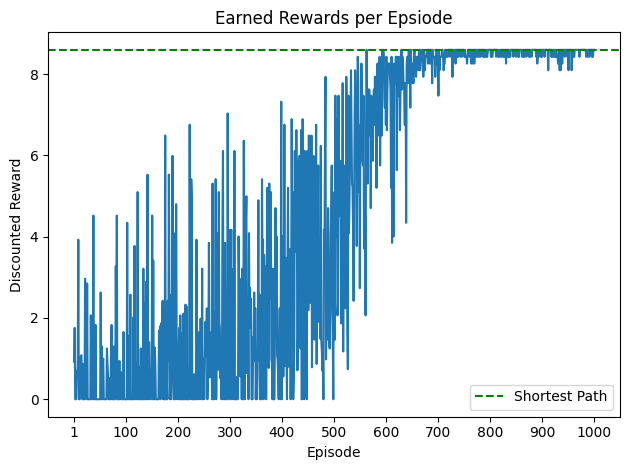

In [5]:
# plot state-value function
plt.title("Value Function")
plot_path(maze, example_goal_path)
plt.imshow(V.reshape(maze.shape), cmap='hot', alpha=0.82)
plt.tight_layout()
plt.show()

# plot earned reward
shortest_path_length = 16
plt.plot(np.arange(1, n_episodes+1), earned_rewards)
plt.axhline(goal_value * gamma**(shortest_path_length - 1), color='green', linestyle='--', label='Shortest Path')
plt.xticks(np.concatenate([np.ones(1), np.arange(100, n_episodes+1, 100)]))
plt.xlabel('Episode')
plt.ylabel('Discounted Reward')
plt.title('Earned Rewards per Epsiode')
plt.legend()
plt.tight_layout()
plt.show()

The value function shows position / states along the shortest path have higher values (towards white) than other states (towards red / black). There is an ascending gradient of values along the shortest path due to discounting of future value. Since the goal is absorbing, the goal state (or a state before when rewarding transitions instead of states) shows the highest value.

The learning curves shows the actor-critic converges to the optimal solution (earned reward for shortest path from start to goal of 16 steps, smaller than the goal value of 10 due to the discounting) after around 700 epsiodes, with an example path shown in green above. 

## Part 2: Improvement with SR

In [6]:
def compute_transition_matrix(maze):
    # for a given maze, compute the transition matrix from any state to any other state under a random walk policy
    # (you will need to think of a good way to map any 2D grid coordinates onto a single number for this)

    # create a matrix over all state pairs
    transitions = np.zeros((maze.size, maze.size))

    # iterate over all states, filling in the transition probabilities to all other states on the next step (only one step into the future)
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            # check if state is valid
            if maze[i, j] == 0:
                # iterate over all possible moves
                for move in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    new_i, new_j = i + move[0], j + move[1]
                    # check if new state is valid
                    if new_i >= 0 and new_i < maze.shape[0] and new_j >= 0 and new_j < maze.shape[1] and maze[new_i, new_j] == 0:
                        transitions[i*maze.shape[1] + j, new_i*maze.shape[1] + new_j] = 1
    
    # normalize transitions
    transitions /= transitions.sum(axis=1, keepdims=True)

    # remove NaNs
    transitions[np.isnan(transitions)] = 0

    return transitions

def analytical_sr(transitions, gamma):
    return np.linalg.inv(np.eye(transitions.shape[0]) - gamma * transitions)

In [7]:
# compute the SR for all states, based on the transition matrix
# note that we use a lower discounting here, to keep the SR more local
transitions = compute_transition_matrix(maze)
SR = analytical_sr(transitions, 0.8)

M_SR, V_SR, earned_rewards_SR, example_goal_path_SR = actor_critic(SR, n_steps=n_steps, alpha=alpha, gamma=gamma, n_episodes=n_episodes)

/var/folders/yf/pf3_bqj55n55b17z1ydbr5dc0000gn/T/ipykernel_32575/1793342528.py:21: RuntimeWarning: invalid value encountered in divide
  transitions /= transitions.sum(axis=1, keepdims=True)


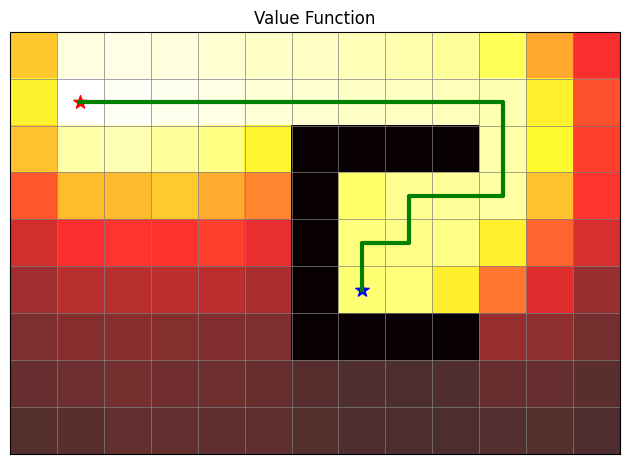

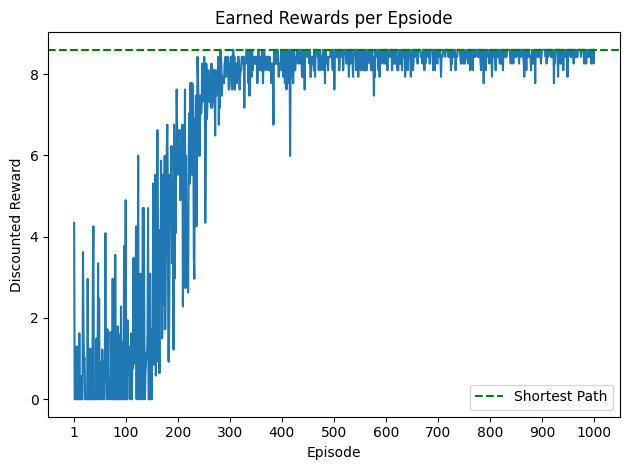

In [8]:
# plot state-value function
plt.title("Value Function")
plot_path(maze, example_goal_path_SR)
plt.imshow(V_SR.reshape(maze.shape), cmap='hot', alpha=0.82)
plt.tight_layout()
plt.show()

# plot earned reward
shortest_path_length = 16
plt.plot(np.arange(1, n_episodes+1), earned_rewards_SR)
plt.axhline(goal_value * gamma**(shortest_path_length - 1), color='green', linestyle='--', label='Shortest Path')
plt.xticks(np.concatenate([np.ones(1), np.arange(100, n_episodes+1, 100)]))
plt.xlabel('Episode')
plt.ylabel('Discounted Reward')
plt.title('Earned Rewards per Epsiode')
plt.legend()
plt.tight_layout()
plt.show()

The learning curve shows faster learning, i.e. convergence to the optimal solution, for using the successor representation compared to using the one-hot representation from part 1. The value function shows why: after finding the goal once, due to the successor representation, the critic can correctly learn values of never visited states after propagating the goal value back, leading to higher values even of seldomly visited states compared to part 1.

## Part 3: Re-learn SR

In [9]:
valid_states = np.arange(maze.size)[np.any(transitions, axis = 0)] # valid states == states that have at least one transition to another state

def random_start():
    # define yourself a function to return a random (non-wall) starting state to pass into the actor_critic function
    return np.random.choice(valid_states)

In [10]:
goal = np.array([1, 1])
SR_learned = analytical_sr(compute_transition_matrix(maze), 0.8).T
M_rl, V_rl, earned_rewards_rl, example_goal_path_rl = actor_critic(SR_learned, n_steps=n_steps, alpha=alpha, gamma=gamma, n_episodes=n_episodes, update_sr=True, start_func=random_start)

/var/folders/yf/pf3_bqj55n55b17z1ydbr5dc0000gn/T/ipykernel_32575/1793342528.py:21: RuntimeWarning: invalid value encountered in divide
  transitions /= transitions.sum(axis=1, keepdims=True)


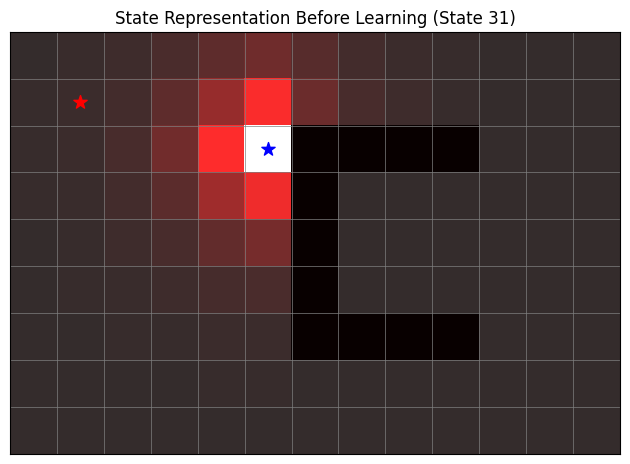

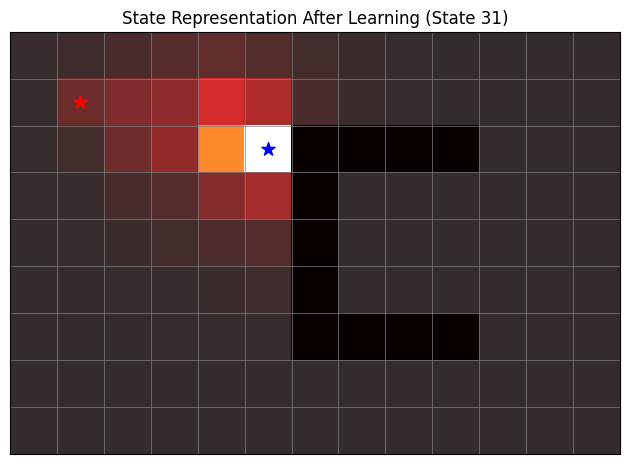

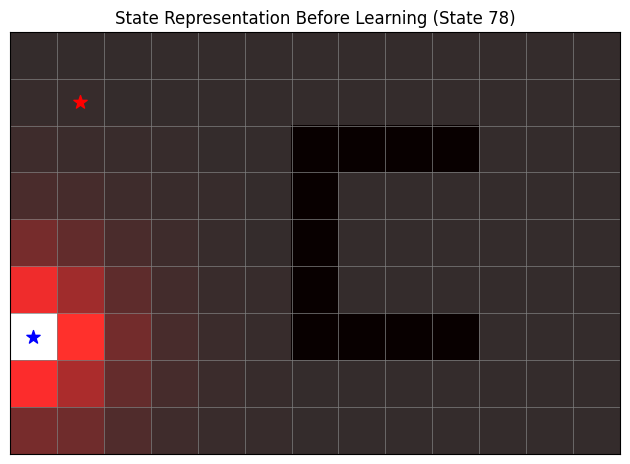

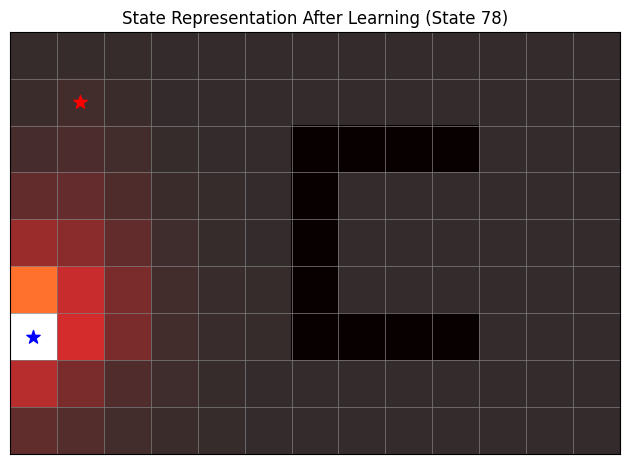

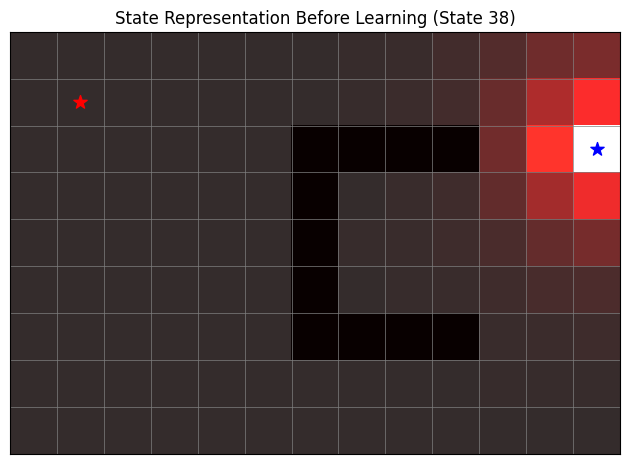

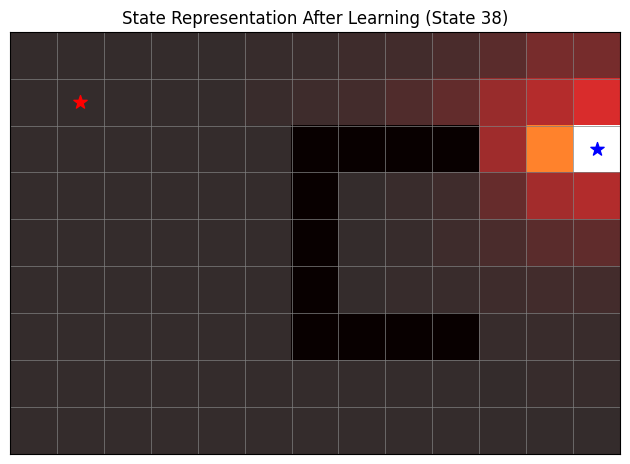

In [11]:
# plot the SR of some states after this learning, also anything else you want
# lt.matshow(SR_learned, cmap='hot')
for i in range(3):
    random_state = random_start()
    plt.title("State Representation Before Learning (State {})".format(random_state))
    plot_maze(maze, start = state_to_position(random_state))
    plt.imshow(SR[random_state].reshape(maze.shape), cmap='hot', alpha=0.83)
    plt.tight_layout()
    plt.show()
    
    plt.title("State Representation After Learning (State {})".format(random_state))
    plot_maze(maze, start = state_to_position(random_state))
    plt.imshow(SR_learned[random_state].reshape(maze.shape), cmap='hot', alpha=0.83)
    plt.tight_layout()
    plt.show()

Compared to the successor representation of a random walk, the learned successor repressentation shows a higher occupation of states closer to the goal / along the path to the goal, since those states are more likely to be visited after learning.

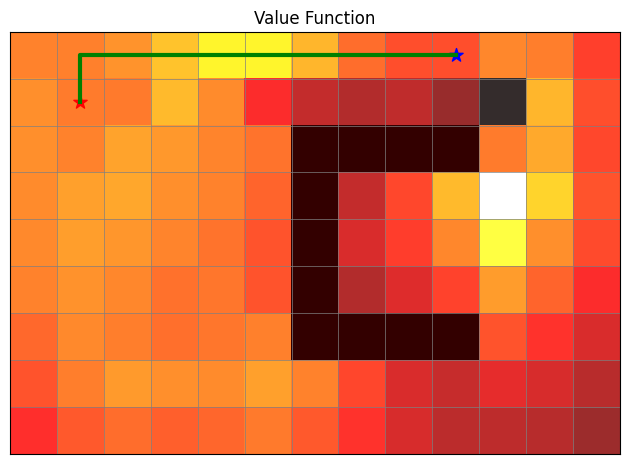

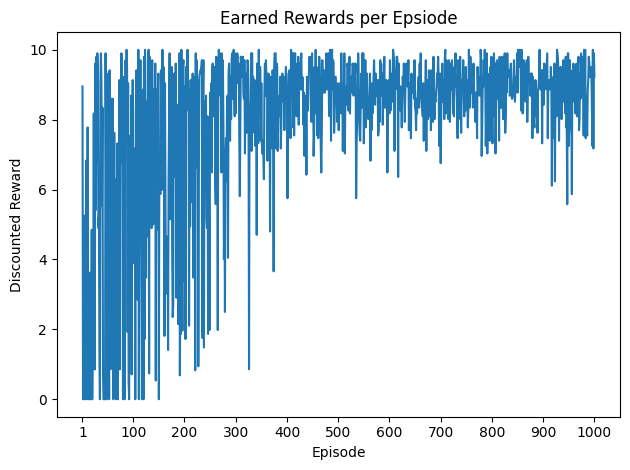

In [12]:
# plot state-value function
plt.title("Value Function")
plot_path(maze, example_goal_path_rl)
plt.imshow(V_rl.reshape(maze.shape), cmap='hot', alpha=0.83)
plt.tight_layout()
plt.show()

# plot earned reward
plt.plot(np.arange(1, n_episodes+1), earned_rewards_rl)
plt.xticks(np.concatenate([np.ones(1), np.arange(100, n_episodes+1, 100)]))
plt.xlabel('Episode')
plt.ylabel('Discounted Reward')
plt.title('Earned Rewards per Epsiode')
plt.tight_layout()
plt.show()

## Part 4: How does re-learned SR affect future policy changes?

In [13]:
goal = np.array([5, 5])
goal_state = position_to_state(goal)

n_runs = 20
n_episodes = 1000
earned_rewards_per_run_original = np.zeros((n_runs, n_episodes))
earned_rewards_per_run_relearned = np.zeros((n_runs, n_episodes))

for i in tqdm(range(n_runs), desc="runs"):
    # run with random walk SR
    M, V, earned_rewards_original, _ = actor_critic(SR, n_steps=n_steps, alpha=alpha, gamma=gamma, n_episodes=n_episodes)
    earned_rewards_per_run_original[i, :] = earned_rewards_original

    # run with updated SR 
    M, V, earned_rewards_relearned, _ = actor_critic(SR_learned, n_steps=n_steps, alpha=alpha, gamma=gamma, n_episodes=n_episodes)
    earned_rewards_per_run_relearned[i, :] = earned_rewards_relearned

runs:   0%|          | 0/20 [00:00<?, ?it/s]

runs: 100%|██████████| 20/20 [01:22<00:00,  4.11s/it]


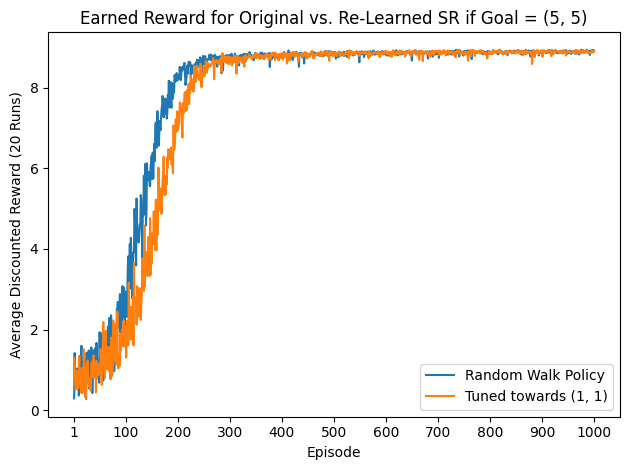

In [14]:
# plot the performance averages of the two types of learners
earned_rewards_original_mean = earned_rewards_per_run_original.mean(axis=0)
earned_rewards_relearned_mean = earned_rewards_per_run_relearned.mean(axis=0)

plt.title('Earned Reward for Original vs. Re-Learned SR if Goal = (5, 5)')
plt.plot(np.arange(1, n_episodes+1), earned_rewards_original_mean, label='Random Walk Policy')
plt.plot(np.arange(1, n_episodes+1), earned_rewards_relearned_mean, label='Tuned towards (1, 1)')
plt.xlabel('Episode')
plt.ylabel('Average Discounted Reward (20 Runs)')
plt.xticks(np.concatenate([np.ones(1), np.arange(100, n_episodes+1, 100)]))
plt.legend()
plt.tight_layout()

The learning curve for the re-learned successor representation (tuned towards not the goal) shows a lower slope and slower convergence to the optimal solution compared to the learning curve of the original successor representation (of a random walk policy). This can be explained by the fact that the tuned SR introduces an initial bias of going favoring a wrong goal position, while the original SR introduces no bias. Thus in the first case, the actor only later finds and learsn to move towards the new goal. 

# Part 5: Value Initialization

In [ ]:
# reset goal
goals = np.array([1, 1])
goal_state = position_to_state(goal)

# run some learners with different value weight w initializations
v_inits = [0, 0.1, 1, 10, 45, 90]
n_runs = 12
n_episodes = 1000

earned_rewards_per_v_init_and_run_sr = np.zeros((len(v_inits), n_runs, n_episodes))
earned_rewards_per_v_init_and_run_one_hot = np.zeros_like(earned_rewards_per_v_init_and_run_sr)

for i, v_init in enumerate(tqdm(v_inits, desc="v_inits")):
    for run in tqdm(range(n_runs), desc="runs", leave=True):
        M, V, earned_rewards_sr, _ = actor_critic(SR, n_steps=n_steps, alpha=alpha, gamma=gamma, n_episodes=n_episodes, v_init=v_init)
        earned_rewards_per_v_init_and_run_sr[i, run, :] = earned_rewards_sr
        
        M, V, earned_rewards_one_hot, _ = actor_critic(one_hot_representation, n_steps=n_steps, alpha=alpha, gamma=gamma, n_episodes=n_episodes, v_init=v_init)
        earned_rewards_per_v_init_and_run_one_hot[i, run, :] = earned_rewards_one_hot

In [ ]:
# plot the resulting learning curves
earned_rewards_per_v_init_and_run_sr_mean = earned_rewards_per_v_init_and_run_sr.mean(axis=1)
earned_rewards_per_v_init_and_run_one_hot_mean = earned_rewards_per_v_init_and_run_one_hot.mean(axis=1)

# SR plot
plt.title('Learning Curves for Successor Representation')
for i, v_init in enumerate(v_inits):
    plt.plot(np.arange(1, n_episodes+1), earned_rewards_per_v_init_and_run_sr_mean[i, :], label=str(v_init))
# plt.plot(np.arange(1, n_episodes+1), earned_rewards_relearned_mean, label='Tuned towards (1, 1)')
plt.xlabel('Episode')
plt.ylabel(f'Average Discounted Reward ({n_runs} Runs)')
plt.xticks(np.concatenate([np.ones(1), np.arange(100, n_episodes+1, 100)]))
plt.legend(title="Initial Weights")
plt.tight_layout()
plt.show()

# one-hot plot
plt.title('Learning Curves for One Hot Representation')
for i, v_init in enumerate(v_inits):
    plt.plot(np.arange(1, n_episodes+1), earned_rewards_per_v_init_and_run_one_hot_mean[i, :], label=str(v_init))
plt.xlabel('Episode')
plt.ylabel(f'Average Discounted Reward ({n_runs} Runs)')
plt.xticks(np.concatenate([np.ones(1), np.arange(100, n_episodes+1, 100)]))
plt.legend(title="Initial Weights")
plt.tight_layout()
plt.show()

For all weight initializations, learning with the successor representation is faster than using the one-hot representation, as observed in part 2. High weight initializations > 1 converge more slowly (or not at all, at least after 1000 episodes) to the optimal solution, since with higher initial values it takes more updates (assuming equal occupation and learning rate) to increase the difference between values of different states and thus take optimal states instead of suboptimal states. Initial positive weights smaller equal 1 are observed to lead to faster learning than for zero weight initialization, clearly for the one-hot representation and also in the beginning of learning curves for higher weights than 1, e.g. 10. 